**NAME**: SURAYA ADNIN BINTI JOHARI

**NO. MATRIKS**: P137383

**SUBJECT CODE**: STQD6324

**SUBJECT NAME**: DATA MANAGEMENT

**ASSIGNMENT 2**: Airline on-time performance

This project aims to deepdive airline-on-time performance with given problem statement:
1. What are the optimal times of day, days of week and times of the year for minimizing flight delays?
2. What are the primary factors contributiong to flight delays?
3. What factors predominantly lead to flight cancellations?
4. Which flight experiences the most frequent and significant delays and cancellation?

# 1.0 Data Management

This section is where we managed the data by merging 2008 data with airports, plane_data and carriers data from source (https://www.kaggle.com/datasets/wenxingdi/data-expo-2009-airline-on-time-data/data?select=1993.csv)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Code used in Hive to merge data 2008, plane_data, airports and carrier

# Join 2008 data with airplanes
CREATE TABLE merged_data AS
SELECT f.*, a.Type AS AirplaneType, a.Manufacturer AS AirplaneManufacturer
FROM flights_2008 f
JOIN airplanes a ON f.TailNum = a.TailNum;

# Join the above data with carriers and plane_data
CREATE TABLE merged_data AS
SELECT f.*, c.Description AS CarrierDescription, pd.Type AS PlaneType, pd.Manufacturer AS PlaneManufacturer
FROM merged_data f
LEFT JOIN carriers c ON f.UniqueCarrier = c.Code
LEFT JOIN plane_data pd ON f.TailNum = pd.TailNum;


In [44]:
#Load merged data from Hive

merged_data = pd.read_csv('/content/drive/MyDrive/merged_data.csv', sep=',')

<ipython-input-44-8201227f73e2>:3: DtypeWarning: Columns (31,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv('/content/drive/MyDrive/merged_data.csv', sep=',')


# 2.0 Data Analysis

This section is where we analyzed the given data based on four given problem statements

## 2.1 What are the optimal times of day, days of the week and times of the year for minimizing flight delays?

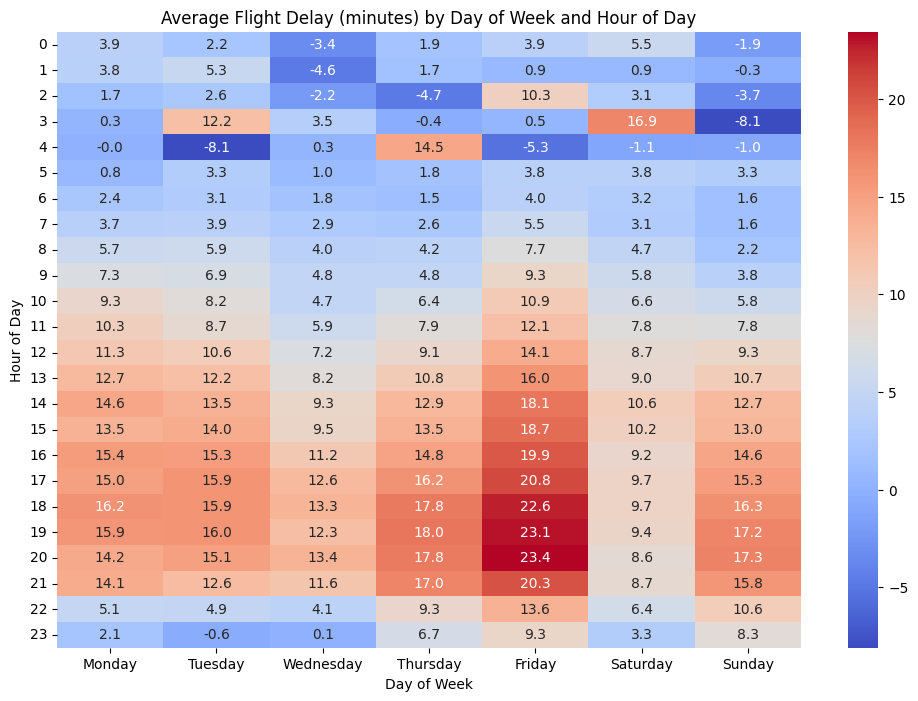



The optimal time for minimizing flight delays os at 4 o'clock on 1 (Tuesday)


Average delay time at this optimal time: -8.09 minutes.


In [ ]:
# To convert the date columns to datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Year'].astype(str) + '-' +
                                    merged_data['Month'].astype(str) + '-' +
                                    merged_data['DayofMonth'].astype(str))

# Extract day of week (0 = Monday, 6 = Sunday) and hour of the day from the 'Date column
merged_data['DayOfWeek']=merged_data['Date'].dt.dayofweek
merged_data['HourOfDay']=merged_data['CRSDepTime'] // 100

# Calculate average delay times grouped by dat of week and hour of day
avg_delay_by_day_hour = merged_data.groupby(['DayOfWeek', 'HourOfDay'])['ArrDelay'].mean()

# Find the minimum delay time
min_delay = avg_delay_by_day_hour.min()

# Find the corresponding day of week and hour of day for the minimum delay
optimal_time = avg_delay_by_day_hour.idxmin()
optimal_day_of_week = optimal_time[0]  # index 0 corresponds to DayOfWeek
optimal_hour_of_day = optimal_time[1]  # index 1 corresponds to HourOfDay

## Visualization portion ##
# Reshape the data to create a pivot table for heatmap
pivot_table = avg_delay_by_day_hour.reset_index().pivot(index='HourOfDay', columns='DayOfWeek', values='ArrDelay')

# Define days of the week for proper labeling in axis
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".1f", xticklabels=days_of_week)
plt.title('Average Flight Delay (minutes) by Day of Week and Hour of Day')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.yticks(rotation=0)
plt.show()
print("\n")
print(f"The optimal time for minimizing flight delays os at {optimal_hour_of_day} o'clock on {optimal_day_of_week} (Tuesday)")
print("\n")
print(f"Average delay time at this optimal time: {min_delay:.2f} minutes.")

## 2.2 What are the primary factors contributing to flight delays?

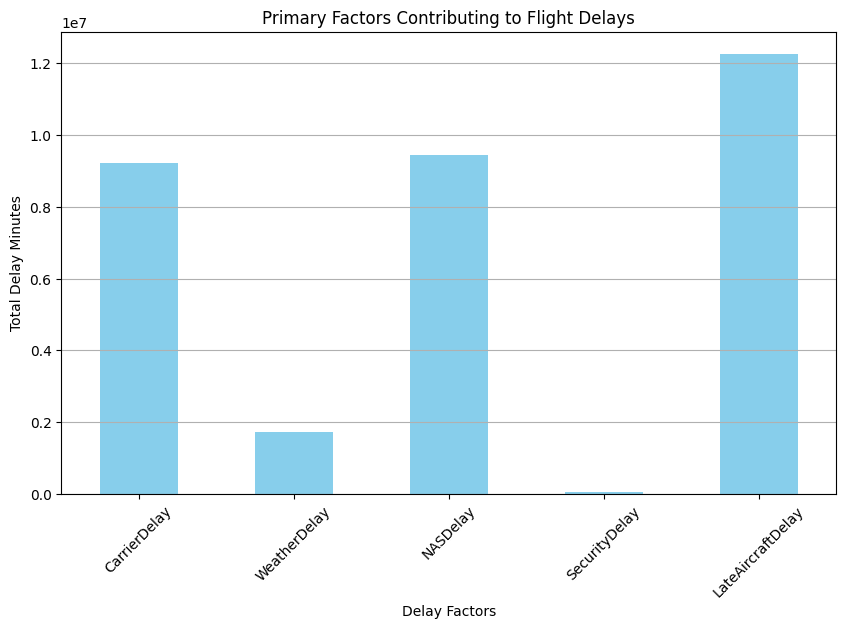



The primary factor contributing to flight delays is LateAircraftDelay with a total delay of 12262628.0 minutes.


In [ ]:
# Group by delay factors and sum the delays
delay_factors = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
delay_factors_sum = merged_data[delay_factors].sum()

# Identify the primary factor (maximum delay)
primary_delay_factor = delay_factors_sum.idxmax()
max_delay_minutes = delay_factors_sum.max()

## Visualization ##
plt.figure(figsize=(10, 6))
delay_factors_sum.plot(kind='bar', color='skyblue')
plt.title('Primary Factors Contributing to Flight Delays')
plt.xlabel('Delay Factors')
plt.ylabel('Total Delay Minutes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# Print results
print("\n")
print(f"The primary factor contributing to flight delays is {primary_delay_factor} with a total delay of {max_delay_minutes} minutes.")

## 2.3 What factors predominantly lead to flight cancellations?

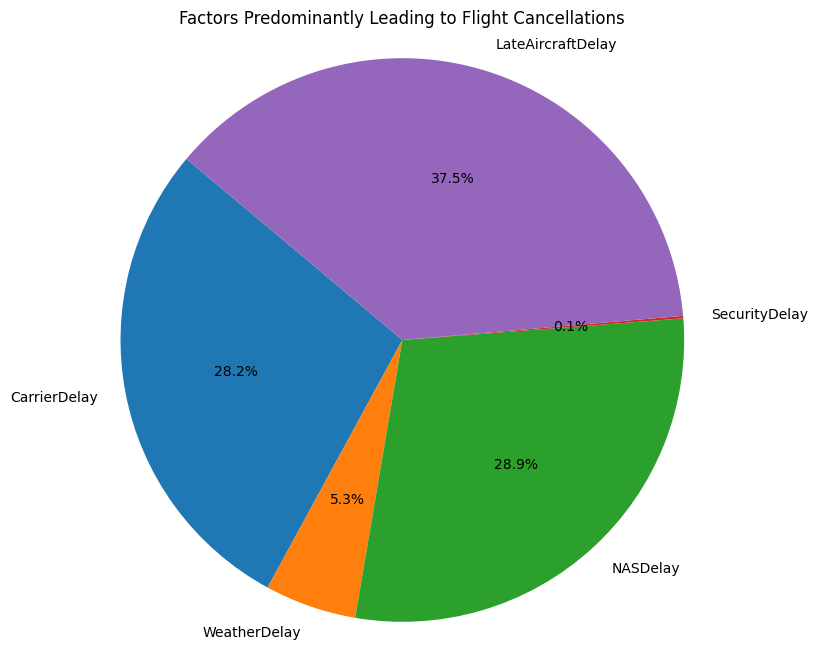



The predominant factor leading to flight cancellations is LateAircraftDelay with 12262628 cancellations.


In [ ]:
# Count the number of cancellations and group by cancellation reasons
cancellation_reasons = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
cancellation_counts = merged_data[cancellation_reasons].sum()

# Identify the predominant cancellation reason (maximum cancellations)
predominant_cancellation_reason = cancellation_counts.idxmax()
max_cancellations = cancellation_counts.max()
max_cancel = round(max_cancellations)

# Visualization
plt.figure(figsize=(8, 8))
plt.pie(cancellation_counts, labels=cancellation_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Factors Predominantly Leading to Flight Cancellations')
plt.axis('equal')
plt.show()

# Print results
print("\n")
print(f"The predominant factor leading to flight cancellations is {predominant_cancellation_reason} with {max_cancel} cancellations.")

## 2.4 Which flight experiences the most frequent and significant delays and cancellations?

In [ ]:
# Group by flight number and calculate counts of delays and cancellations
flight_delays = merged_data.groupby('FlightNum')['ArrDelay'].agg(['count', 'mean'])
flight_cancellations = merged_data.groupby('FlightNum')['Cancelled'].sum()

### 2.4.1 Flight that experience the most frequent delays (count)

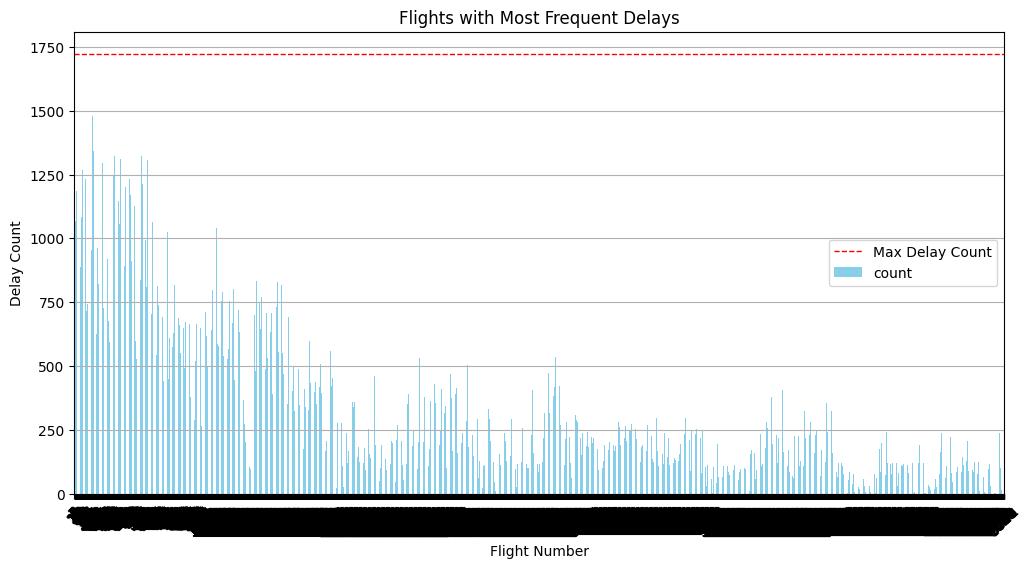



The flight with the most frequent delays (count) is Flight 511.


In [ ]:
# Identify the flight with the most frequent delays (count)
max_delay_count_flight = flight_delays['count'].idxmax()

# Visualization
plt.figure(figsize=(12, 6))
flight_delays_count.plot(kind='bar', color='skyblue')
plt.title('Flights with Most Frequent Delays')
plt.xlabel('Flight Number')
plt.ylabel('Delay Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.axhline(flight_delays_count.max(), color='red', linestyle='--', linewidth=1, label='Max Delay Count')
plt.legend()
plt.show()

# Description
print("\n")
print(f"The flight with the most frequent delays (count) is Flight {max_delay_count_flight}.")

### 2.4.2 Flight that experience the most significant delays (mean)

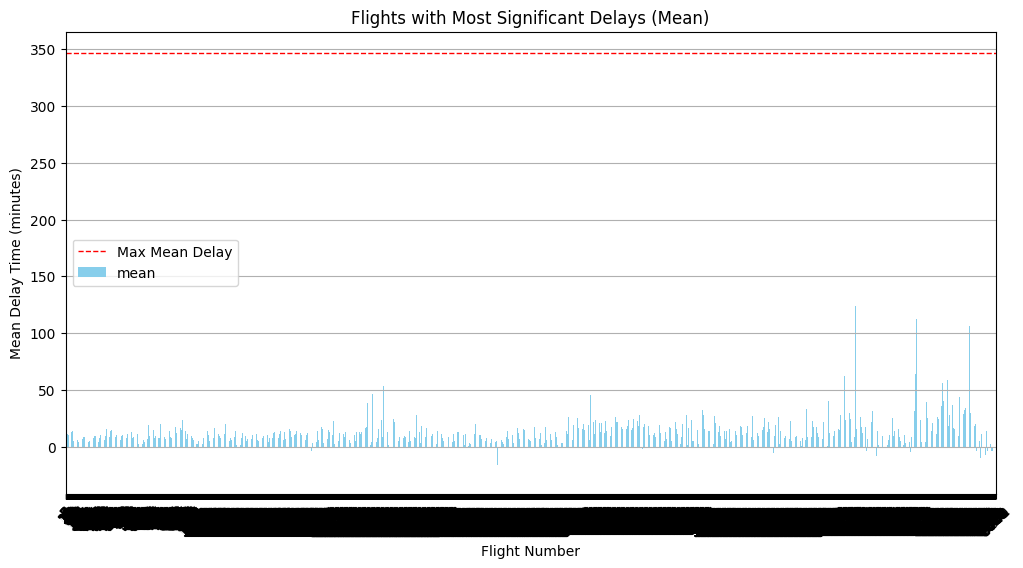



The flight with the most significant delays (mean) is Flight 7487.


In [ ]:
# To identify the flight with the most significant delays (mean)
max_mean_delay_flight = flight_delays['mean'].idxmax()

# Visualization
plt.figure(figsize=(12, 6))
flight_delays_mean.plot(kind='bar', color='skyblue')
plt.title('Flights with Most Significant Delays (Mean)')
plt.xlabel('Flight Number')
plt.ylabel('Mean Delay Time (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.axhline(flight_delays_mean.max(), color='red', linestyle='--', linewidth=1, label='Max Mean Delay')
plt.legend()
plt.show()

# Description
print("\n")
print(f"The flight with the most significant delays (mean) is Flight {max_mean_delay_flight}.")

### 2.4.3 Flight that experience the most cancellations

In [46]:
# To identify the flight with the most cancellations
max_cancellations_flight = flight_cancellations.idxmax()
max_cancellations_count = flight_cancellations.max()

# Description
print(f"The flight with the most cancellations is Flight {max_cancellations_flight} with {max_cancellations_count} cancellations.")

The flight with the most cancellations is Flight 5886 with 70 cancellations.


In [ ]:
### Merging data using Hive

-- Create an external table for data_2008
CREATE EXTERNAL TABLE IF NOT EXISTS data_2008 (
    Year int,
    Month int,
    DayofMonth int,
    DayOfWeek int,
    DepTime string,
    CRSDepTime string,
    ArrTime string,
    CRSArrTime string,
    UniqueCarrier string,
    FlightNum string,
    TailNum string,
    ActualElapsedTime string,
    CRSElapsedTime string,
    AirTime string,
    ArrDelay string,
    DepDelay string,
    Origin string,
    Dest string,
    Distance string,
    TaxiIn string,
    TaxiOut string,
    Cancelled string,
    CancellationCode string,
    Diverted string,
    CarrierDelay string,
    WeatherDelay string,
    NASDelay string,
    SecurityDelay string,
    LateAircraftDelay string
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/path/to/data_2008';

-- Create an external table for carriers
CREATE EXTERNAL TABLE IF NOT EXISTS carriers (
    Code string,
    Description string
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/path/to/carriers';

-- Create an external table for planes
CREATE EXTERNAL TABLE IF NOT EXISTS planes (
    tailnum string,
    type string,
    manufacturer string,
    issue_date string,
    model string,
    status string,
    aircraft_type string,
    engine_type string,
    year int
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/path/to/planes';

-- Create an external table for airports
CREATE EXTERNAL TABLE IF NOT EXISTS airports (
    iata string,
    airport string,
    city string,
    state string,
    country string,
    lat string,
    long string
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/path/to/airports';

-- Merge data_2008 with carriers
CREATE TABLE merged_data AS
SELECT d.*, c.Description as CarrierDescription
FROM data_2008 d
LEFT JOIN carriers c
ON d.UniqueCarrier = c.Code;

-- Merge merged_data with planes
INSERT OVERWRITE TABLE merged_data
SELECT m.*, p.type, p.manufacturer, p.model, p.status
FROM merged_data m
LEFT JOIN planes p
ON m.TailNum = p.tailnum;

-- Merge merged_data with airports for origin
INSERT OVERWRITE TABLE merged_data
SELECT m.*, a.airport as OriginAirport, a.city as OriginCity, a.state as OriginState
FROM merged_data m
LEFT JOIN airports a
ON m.Origin = a.iata;

-- Merge merged_data with airports for destination
INSERT OVERWRITE TABLE merged_data
SELECT m.*, a.airport as DestAirport, a.city as DestCity, a.state as DestState
FROM merged_data m
LEFT JOIN airports a
ON m.Dest = a.iata;

-- Drop intermediate columns if necessary
ALTER TABLE merged_data DROP COLUMN TailNum, UniqueCarrier, Origin, Dest;

-- Show the final merged data
SELECT * FROM merged_data LIMIT 10;
